In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 220/220 [01:01<00:00,  3.61it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 220/220 [00:02<00:00, 96.53it/s] 


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 200/200 [01:13<00:00,  2.70it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 200/200 [00:01<00:00, 106.49it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   1%|          | 15/2500 [00:00<01:23, 29.65it/s]

Epoch 10/2500, Loss: 0.5261
Test Accuracy at Epoch 10: 72.02%
Test F1-score at Epoch 10: 0.7432
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.73      0.66      0.69       160
non_infringement       0.72      0.77      0.74       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.72      0.72      0.72       336

New best model saved with F1-score 0.7432 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.73      0.66      0.69       160
non_infringement       0.72      0.77      0.74       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.72      0.72      0.72       336



Training Epochs:   1%|          | 23/2500 [00:00<01:21, 30.34it/s]

Epoch 20/2500, Loss: 0.4790
Test Accuracy at Epoch 20: 70.54%
Test F1-score at Epoch 20: 0.7755
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.93      0.41      0.57       160
non_infringement       0.65      0.97      0.78       176

        accuracy                           0.71       336
       macro avg       0.79      0.69      0.67       336
    weighted avg       0.78      0.71      0.68       336

New best model saved with F1-score 0.7755 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.93      0.41      0.57       160
non_infringement       0.65      0.97      0.78       176

        accuracy                           0.71       336
       macro avg       0.79      0.69      0.67       336
    weighted avg       0.78      0.71      0.68       336



Training Epochs:   1%|▏         | 33/2500 [00:01<01:16, 32.07it/s]

Epoch 30/2500, Loss: 0.4075
Test Accuracy at Epoch 30: 75.00%
Test F1-score at Epoch 30: 0.7857
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.82      0.61      0.70       160
non_infringement       0.71      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

New best model saved with F1-score 0.7857 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.82      0.61      0.70       160
non_infringement       0.71      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:   2%|▏         | 44/2500 [00:01<01:01, 39.93it/s]

Epoch 40/2500, Loss: 0.3542
Test Accuracy at Epoch 40: 72.32%
Test F1-score at Epoch 40: 0.7533
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       160
non_infringement       0.71      0.81      0.75       176

        accuracy                           0.72       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:   2%|▏         | 56/2500 [00:01<00:58, 41.73it/s]

Epoch 50/2500, Loss: 0.3004
Test Accuracy at Epoch 50: 75.00%
Test F1-score at Epoch 50: 0.7812
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:   3%|▎         | 67/2500 [00:01<01:00, 40.38it/s]

Epoch 60/2500, Loss: 0.2575
Test Accuracy at Epoch 60: 75.89%
Test F1-score at Epoch 60: 0.7851
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.79      0.67      0.73       160
non_infringement       0.74      0.84      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.76       336
    weighted avg       0.76      0.76      0.76       336



Training Epochs:   3%|▎         | 78/2500 [00:02<00:56, 42.61it/s]

Epoch 70/2500, Loss: 0.2205
Test Accuracy at Epoch 70: 76.79%
Test F1-score at Epoch 70: 0.7914
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.84      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.77      0.77       336

New best model saved with F1-score 0.7914 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.84      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.77      0.77       336



Training Epochs:   3%|▎         | 83/2500 [00:02<01:03, 38.30it/s]

Epoch 80/2500, Loss: 0.2999
Test Accuracy at Epoch 80: 74.40%
Test F1-score at Epoch 80: 0.7584
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.74      0.72      0.73       160
non_infringement       0.75      0.77      0.76       176

        accuracy                           0.74       336
       macro avg       0.74      0.74      0.74       336
    weighted avg       0.74      0.74      0.74       336



Training Epochs:   4%|▍         | 94/2500 [00:02<01:00, 39.46it/s]

Epoch 90/2500, Loss: 0.2115
Test Accuracy at Epoch 90: 73.21%
Test F1-score at Epoch 90: 0.7458
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.72      0.71      0.72       160
non_infringement       0.74      0.75      0.75       176

        accuracy                           0.73       336
       macro avg       0.73      0.73      0.73       336
    weighted avg       0.73      0.73      0.73       336



Training Epochs:   4%|▍         | 109/2500 [00:03<00:56, 42.10it/s]

Epoch 100/2500, Loss: 0.1926
Test Accuracy at Epoch 100: 78.57%
Test F1-score at Epoch 100: 0.8135
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.85      0.67      0.75       160
non_infringement       0.75      0.89      0.81       176

        accuracy                           0.79       336
       macro avg       0.80      0.78      0.78       336
    weighted avg       0.80      0.79      0.78       336

New best model saved with F1-score 0.8135 at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.85      0.67      0.75       160
non_infringement       0.75      0.89      0.81       176

        accuracy                           0.79       336
       macro avg       0.80      0.78      0.78       336
    weighted avg       0.80      0.79      0.78       336



Training Epochs:   5%|▍         | 114/2500 [00:03<01:07, 35.42it/s]

Epoch 110/2500, Loss: 0.1503
Test Accuracy at Epoch 110: 80.95%
Test F1-score at Epoch 110: 0.8408
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.94      0.64      0.76       160
non_infringement       0.75      0.96      0.84       176

        accuracy                           0.81       336
       macro avg       0.84      0.80      0.80       336
    weighted avg       0.84      0.81      0.80       336

New best model saved with F1-score 0.8408 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.94      0.64      0.76       160
non_infringement       0.75      0.96      0.84       176

        accuracy                           0.81       336
       macro avg       0.84      0.80      0.80       336
    weighted avg       0.84      0.81      0.80       336



Training Epochs:   5%|▌         | 126/2500 [00:03<00:56, 41.91it/s]

Epoch 120/2500, Loss: 0.1469
Test Accuracy at Epoch 120: 76.19%
Test F1-score at Epoch 120: 0.7838
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.74       160
non_infringement       0.75      0.82      0.78       176

        accuracy                           0.76       336
       macro avg       0.76      0.76      0.76       336
    weighted avg       0.76      0.76      0.76       336



Training Epochs:   5%|▌         | 137/2500 [00:03<00:56, 41.65it/s]

Epoch 130/2500, Loss: 0.1207
Test Accuracy at Epoch 130: 77.98%
Test F1-score at Epoch 130: 0.8083
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       160
non_infringement       0.74      0.89      0.81       176

        accuracy                           0.78       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.78      0.78       336

Epoch 140/2500, Loss: 0.1176


Training Epochs:   6%|▌         | 147/2500 [00:03<00:58, 40.03it/s]

Test Accuracy at Epoch 140: 77.38%
Test F1-score at Epoch 140: 0.7989
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       160
non_infringement       0.75      0.86      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:   6%|▋         | 157/2500 [00:04<00:58, 40.37it/s]

Epoch 150/2500, Loss: 0.2110
Test Accuracy at Epoch 150: 75.89%
Test F1-score at Epoch 150: 0.8103
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.96      0.51      0.67       160
non_infringement       0.69      0.98      0.81       176

        accuracy                           0.76       336
       macro avg       0.83      0.75      0.74       336
    weighted avg       0.82      0.76      0.74       336



Training Epochs:   6%|▋         | 162/2500 [00:04<01:04, 36.42it/s]

Epoch 160/2500, Loss: 0.1253
Test Accuracy at Epoch 160: 74.70%
Test F1-score at Epoch 160: 0.7684
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       160
non_infringement       0.74      0.80      0.77       176

        accuracy                           0.75       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.75      0.75       336



Training Epochs:   7%|▋         | 173/2500 [00:04<00:55, 41.61it/s]

Epoch 170/2500, Loss: 0.0938
Test Accuracy at Epoch 170: 76.79%
Test F1-score at Epoch 170: 0.7926
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.80      0.68      0.74       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.77      0.77       336



Training Epochs:   8%|▊         | 189/2500 [00:04<00:50, 45.56it/s]

Epoch 180/2500, Loss: 0.0840
Test Accuracy at Epoch 180: 76.19%
Test F1-score at Epoch 180: 0.7849
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       160
non_infringement       0.74      0.83      0.78       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.76      0.76      0.76       336

Epoch 190/2500, Loss: 0.0801


Training Epochs:   8%|▊         | 194/2500 [00:05<00:50, 45.58it/s]

Test Accuracy at Epoch 190: 77.38%
Test F1-score at Epoch 190: 0.7968
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.85      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:   8%|▊         | 204/2500 [00:05<00:52, 43.59it/s]

Epoch 200/2500, Loss: 0.0726
Test Accuracy at Epoch 200: 77.68%
Test F1-score at Epoch 200: 0.8011
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.81      0.69      0.75       160
non_infringement       0.75      0.86      0.80       176

        accuracy                           0.78       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.78      0.77       336

Epoch 210/2500, Loss: 0.0670


Training Epochs:   9%|▊         | 215/2500 [00:05<00:54, 41.93it/s]

Test Accuracy at Epoch 210: 77.68%
Test F1-score at Epoch 210: 0.8031
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.82      0.68      0.74       160
non_infringement       0.75      0.87      0.80       176

        accuracy                           0.78       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.78      0.78      0.77       336



Training Epochs:   9%|▉         | 226/2500 [00:05<00:48, 46.59it/s]

Epoch 220/2500, Loss: 0.0639
Test Accuracy at Epoch 220: 77.98%
Test F1-score at Epoch 220: 0.8053
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.83      0.68      0.75       160
non_infringement       0.75      0.87      0.81       176

        accuracy                           0.78       336
       macro avg       0.79      0.78      0.78       336
    weighted avg       0.79      0.78      0.78       336



Training Epochs:   9%|▉         | 237/2500 [00:06<00:51, 44.13it/s]

Epoch 230/2500, Loss: 0.0615
Test Accuracy at Epoch 230: 77.08%
Test F1-score at Epoch 230: 0.7968
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       160
non_infringement       0.74      0.86      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:  10%|▉         | 248/2500 [00:06<00:46, 48.20it/s]

Epoch 240/2500, Loss: 0.0594
Test Accuracy at Epoch 240: 77.08%
Test F1-score at Epoch 240: 0.7947
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.85      0.79       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.77      0.77      0.77       336



Training Epochs:  10%|█         | 259/2500 [00:06<00:48, 45.78it/s]

Epoch 250/2500, Loss: 0.0577
Test Accuracy at Epoch 250: 76.49%
Test F1-score at Epoch 250: 0.7916
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 260/2500, Loss: 0.0563


Training Epochs:  11%|█         | 264/2500 [00:06<00:48, 46.47it/s]

Test Accuracy at Epoch 260: 76.49%
Test F1-score at Epoch 260: 0.7916
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  11%|█         | 280/2500 [00:07<00:47, 46.84it/s]

Epoch 270/2500, Loss: 0.0551
Test Accuracy at Epoch 270: 76.79%
Test F1-score at Epoch 270: 0.7937
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.77      0.77       336

Epoch 280/2500, Loss: 0.0540
Test Accuracy at Epoch 280: 76.49%
Test F1-score at Epoch 280: 0.7916
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  12%|█▏        | 296/2500 [00:07<00:46, 47.19it/s]

Epoch 290/2500, Loss: 0.0531
Test Accuracy at Epoch 290: 76.79%
Test F1-score at Epoch 290: 0.7937
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.77      0.77       336

Epoch 300/2500, Loss: 0.0523


Training Epochs:  12%|█▏        | 306/2500 [00:07<00:50, 43.59it/s]

Test Accuracy at Epoch 300: 76.49%
Test F1-score at Epoch 300: 0.7927
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       160
non_infringement       0.74      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  13%|█▎        | 317/2500 [00:07<00:44, 48.69it/s]

Epoch 310/2500, Loss: 0.0515
Test Accuracy at Epoch 310: 76.79%
Test F1-score at Epoch 310: 0.7947
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.81      0.67      0.73       160
non_infringement       0.74      0.86      0.79       176

        accuracy                           0.77       336
       macro avg       0.78      0.76      0.76       336
    weighted avg       0.77      0.77      0.77       336

Epoch 320/2500, Loss: 0.0510
Test Accuracy at Epoch 320: 76.49%
Test F1-score at Epoch 320: 0.7916


Training Epochs:  13%|█▎        | 328/2500 [00:08<00:46, 46.52it/s]

Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  14%|█▎        | 339/2500 [00:08<00:43, 49.44it/s]

Epoch 330/2500, Loss: 0.0505
Test Accuracy at Epoch 330: 76.49%
Test F1-score at Epoch 330: 0.7916
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  14%|█▍        | 345/2500 [00:08<00:50, 43.05it/s]

Epoch 340/2500, Loss: 0.0497
Test Accuracy at Epoch 340: 77.68%
Test F1-score at Epoch 340: 0.7989
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       160
non_infringement       0.76      0.85      0.80       176

        accuracy                           0.78       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.78      0.78       336

Epoch 350/2500, Loss: 0.0491


Training Epochs:  14%|█▍        | 356/2500 [00:08<00:44, 47.94it/s]

Test Accuracy at Epoch 350: 77.68%
Test F1-score at Epoch 350: 0.7989
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       160
non_infringement       0.76      0.85      0.80       176

        accuracy                           0.78       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.78      0.78       336



Training Epochs:  15%|█▍        | 367/2500 [00:08<00:46, 45.60it/s]

Epoch 360/2500, Loss: 0.0486
Test Accuracy at Epoch 360: 77.68%
Test F1-score at Epoch 360: 0.7989
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       160
non_infringement       0.76      0.85      0.80       176

        accuracy                           0.78       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.78      0.78       336

Epoch 370/2500, Loss: 0.0481
Test Accuracy at Epoch 370: 77.08%
Test F1-score at Epoch 370: 0.7925


Training Epochs:  15%|█▌        | 377/2500 [00:09<00:49, 42.56it/s]

Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       160
non_infringement       0.75      0.84      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.77      0.77       336
    weighted avg       0.77      0.77      0.77       336



Training Epochs:  16%|█▌        | 388/2500 [00:09<00:44, 47.96it/s]

Epoch 380/2500, Loss: 0.0479
Test Accuracy at Epoch 380: 77.08%
Test F1-score at Epoch 380: 0.7936
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.84      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.77      0.77       336
    weighted avg       0.77      0.77      0.77       336

Epoch 390/2500, Loss: 0.0473
Test Accuracy at Epoch 390: 77.08%
Test F1-score at Epoch 390: 0.7936
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.84      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.77      0.77       336
    weighted avg       0.77      0.77      0.77       336



Training Epochs:  16%|█▋        | 409/2500 [00:09<00:43, 47.80it/s]

Epoch 400/2500, Loss: 0.0470
Test Accuracy at Epoch 400: 77.38%
Test F1-score at Epoch 400: 0.7957
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       160
non_infringement       0.76      0.84      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336

Epoch 410/2500, Loss: 0.0466
Test Accuracy at Epoch 410: 77.38%
Test F1-score at Epoch 410: 0.7968


Training Epochs:  17%|█▋        | 414/2500 [00:10<00:50, 41.17it/s]

Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.85      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:  17%|█▋        | 426/2500 [00:10<00:43, 47.41it/s]

Epoch 420/2500, Loss: 0.0463
Test Accuracy at Epoch 420: 77.38%
Test F1-score at Epoch 420: 0.7968
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.85      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:  17%|█▋        | 437/2500 [00:10<00:45, 45.29it/s]

Epoch 430/2500, Loss: 0.0460
Test Accuracy at Epoch 430: 77.08%
Test F1-score at Epoch 430: 0.7936
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.84      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.77      0.77       336
    weighted avg       0.77      0.77      0.77       336

Epoch 440/2500, Loss: 0.0457


Training Epochs:  18%|█▊        | 447/2500 [00:10<00:49, 41.34it/s]

Test Accuracy at Epoch 440: 77.08%
Test F1-score at Epoch 440: 0.7936
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.84      0.79       176

        accuracy                           0.77       336
       macro avg       0.77      0.77      0.77       336
    weighted avg       0.77      0.77      0.77       336



Training Epochs:  18%|█▊        | 458/2500 [00:10<00:44, 46.18it/s]

Epoch 450/2500, Loss: 0.0455
Test Accuracy at Epoch 450: 77.68%
Test F1-score at Epoch 450: 0.7989
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.81      0.70      0.75       160
non_infringement       0.76      0.85      0.80       176

        accuracy                           0.78       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.78      0.78       336

Epoch 460/2500, Loss: 0.0453


Training Epochs:  19%|█▊        | 463/2500 [00:11<00:43, 46.98it/s]

Test Accuracy at Epoch 460: 77.38%
Test F1-score at Epoch 460: 0.7968
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.80      0.69      0.74       160
non_infringement       0.75      0.85      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:  19%|█▉        | 479/2500 [00:11<00:42, 47.21it/s]

Epoch 470/2500, Loss: 0.0450
Test Accuracy at Epoch 470: 77.38%
Test F1-score at Epoch 470: 0.7957
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       160
non_infringement       0.76      0.84      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336

Epoch 480/2500, Loss: 0.0461
Test Accuracy at Epoch 480: 75.00%
Test F1-score at Epoch 480: 0.7680


Training Epochs:  19%|█▉        | 484/2500 [00:11<00:50, 40.16it/s]

Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       160
non_infringement       0.75      0.79      0.77       176

        accuracy                           0.75       336
       macro avg       0.75      0.75      0.75       336
    weighted avg       0.75      0.75      0.75       336



Training Epochs:  20%|█▉        | 496/2500 [00:11<00:45, 43.62it/s]

Epoch 490/2500, Loss: 0.0530
Test Accuracy at Epoch 490: 81.55%
Test F1-score at Epoch 490: 0.8410
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       160
non_infringement       0.77      0.93      0.84       176

        accuracy                           0.82       336
       macro avg       0.83      0.81      0.81       336
    weighted avg       0.83      0.82      0.81       336

New best model saved with F1-score 0.8410 at epoch 490
Best Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       160
non_infringement       0.77      0.93      0.84       176

        accuracy                           0.82       336
       macro avg       0.83      0.81      0.81       336
    weighted avg       0.83      0.82      0.81       336



Training Epochs:  20%|██        | 507/2500 [00:12<00:46, 42.67it/s]

Epoch 500/2500, Loss: 1.9522
Test Accuracy at Epoch 500: 61.90%
Test F1-score at Epoch 500: 0.5328
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.57      0.84      0.68       160
non_infringement       0.74      0.41      0.53       176

        accuracy                           0.62       336
       macro avg       0.66      0.63      0.61       336
    weighted avg       0.66      0.62      0.60       336



Training Epochs:  20%|██        | 512/2500 [00:12<01:03, 31.39it/s]

Epoch 510/2500, Loss: 0.2628
Test Accuracy at Epoch 510: 73.51%
Test F1-score at Epoch 510: 0.7945
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.95      0.47      0.63       160
non_infringement       0.67      0.98      0.79       176

        accuracy                           0.74       336
       macro avg       0.81      0.72      0.71       336
    weighted avg       0.80      0.74      0.72       336



Training Epochs:  21%|██        | 523/2500 [00:12<00:51, 38.43it/s]

Epoch 520/2500, Loss: 0.3324
Test Accuracy at Epoch 520: 75.30%
Test F1-score at Epoch 520: 0.7930
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.69       160
non_infringement       0.71      0.90      0.79       176

        accuracy                           0.75       336
       macro avg       0.78      0.75      0.74       336
    weighted avg       0.77      0.75      0.75       336



Training Epochs:  22%|██▏       | 540/2500 [00:13<00:44, 44.24it/s]

Epoch 530/2500, Loss: 0.3923
Test Accuracy at Epoch 530: 75.00%
Test F1-score at Epoch 530: 0.7910
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.85      0.58      0.69       160
non_infringement       0.70      0.90      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.74      0.74       336
    weighted avg       0.77      0.75      0.74       336

Epoch 540/2500, Loss: 0.2529
Test Accuracy at Epoch 540: 76.49%
Test F1-score at Epoch 540: 0.7927
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       160
non_infringement       0.74      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  22%|██▏       | 557/2500 [00:13<00:40, 48.15it/s]

Epoch 550/2500, Loss: 0.2313
Test Accuracy at Epoch 550: 75.30%
Test F1-score at Epoch 550: 0.7940
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.85      0.58      0.69       160
non_infringement       0.70      0.91      0.79       176

        accuracy                           0.75       336
       macro avg       0.78      0.75      0.74       336
    weighted avg       0.78      0.75      0.75       336

Epoch 560/2500, Loss: 0.2056
Test Accuracy at Epoch 560: 75.89%
Test F1-score at Epoch 560: 0.7949


Training Epochs:  23%|██▎       | 567/2500 [00:13<00:44, 43.20it/s]

Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.84      0.61      0.71       160
non_infringement       0.72      0.89      0.79       176

        accuracy                           0.76       336
       macro avg       0.78      0.75      0.75       336
    weighted avg       0.77      0.76      0.75       336



Training Epochs:  23%|██▎       | 579/2500 [00:13<00:38, 49.33it/s]

Epoch 570/2500, Loss: 0.1868
Test Accuracy at Epoch 570: 73.21%
Test F1-score at Epoch 570: 0.7644
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       160
non_infringement       0.71      0.83      0.76       176

        accuracy                           0.73       336
       macro avg       0.74      0.73      0.73       336
    weighted avg       0.74      0.73      0.73       336

Epoch 580/2500, Loss: 0.1658
Test Accuracy at Epoch 580: 75.89%
Test F1-score at Epoch 580: 0.7907
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  24%|██▍       | 596/2500 [00:14<00:39, 47.96it/s]

Epoch 590/2500, Loss: 0.1479
Test Accuracy at Epoch 590: 75.60%
Test F1-score at Epoch 590: 0.7876
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       160
non_infringement       0.72      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336

Epoch 600/2500, Loss: 0.1316


Training Epochs:  24%|██▍       | 607/2500 [00:14<00:41, 45.88it/s]

Test Accuracy at Epoch 600: 75.30%
Test F1-score at Epoch 600: 0.7833
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  25%|██▍       | 618/2500 [00:14<00:37, 49.92it/s]

Epoch 610/2500, Loss: 0.5254
Test Accuracy at Epoch 610: 78.27%
Test F1-score at Epoch 610: 0.8133
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       160
non_infringement       0.74      0.90      0.81       176

        accuracy                           0.78       336
       macro avg       0.80      0.78      0.78       336
    weighted avg       0.80      0.78      0.78       336



Training Epochs:  25%|██▍       | 624/2500 [00:14<00:44, 42.47it/s]

Epoch 620/2500, Loss: 0.1760
Test Accuracy at Epoch 620: 76.19%
Test F1-score at Epoch 620: 0.7849
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       160
non_infringement       0.74      0.83      0.78       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.76      0.76      0.76       336

Epoch 630/2500, Loss: 0.1654


Training Epochs:  25%|██▌       | 636/2500 [00:15<00:40, 46.03it/s]

Test Accuracy at Epoch 630: 75.00%
Test F1-score at Epoch 630: 0.8000
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.91      0.53      0.67       160
non_infringement       0.69      0.95      0.80       176

        accuracy                           0.75       336
       macro avg       0.80      0.74      0.73       336
    weighted avg       0.80      0.75      0.74       336



Training Epochs:  26%|██▌       | 646/2500 [00:15<00:48, 38.62it/s]

Epoch 640/2500, Loss: 0.1521
Test Accuracy at Epoch 640: 77.38%
Test F1-score at Epoch 640: 0.8051
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       160
non_infringement       0.73      0.89      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336



Training Epochs:  26%|██▋       | 657/2500 [00:15<00:45, 40.93it/s]

Epoch 650/2500, Loss: 0.1306
Test Accuracy at Epoch 650: 77.68%
Test F1-score at Epoch 650: 0.8042
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       160
non_infringement       0.74      0.88      0.80       176

        accuracy                           0.78       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.78      0.78      0.77       336



Training Epochs:  26%|██▋       | 662/2500 [00:15<00:43, 42.10it/s]

Epoch 660/2500, Loss: 0.1178
Test Accuracy at Epoch 660: 77.38%
Test F1-score at Epoch 660: 0.8051
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       160
non_infringement       0.73      0.89      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336



Training Epochs:  27%|██▋       | 679/2500 [00:16<00:40, 45.10it/s]

Epoch 670/2500, Loss: 0.1068
Test Accuracy at Epoch 670: 78.87%
Test F1-score at Epoch 670: 0.8184
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       160
non_infringement       0.74      0.91      0.82       176

        accuracy                           0.79       336
       macro avg       0.81      0.78      0.78       336
    weighted avg       0.80      0.79      0.78       336

Epoch 680/2500, Loss: 0.0978


Training Epochs:  27%|██▋       | 684/2500 [00:16<00:39, 45.67it/s]

Test Accuracy at Epoch 680: 78.57%
Test F1-score at Epoch 680: 0.8154
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.74       160
non_infringement       0.74      0.90      0.82       176

        accuracy                           0.79       336
       macro avg       0.80      0.78      0.78       336
    weighted avg       0.80      0.79      0.78       336



Training Epochs:  28%|██▊       | 694/2500 [00:16<00:41, 43.09it/s]

Epoch 690/2500, Loss: 0.0894
Test Accuracy at Epoch 690: 79.46%
Test F1-score at Epoch 690: 0.8226
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.87      0.67      0.76       160
non_infringement       0.75      0.91      0.82       176

        accuracy                           0.79       336
       macro avg       0.81      0.79      0.79       336
    weighted avg       0.81      0.79      0.79       336

Epoch 700/2500, Loss: 0.0827
Test Accuracy at Epoch 700: 80.06%
Test F1-score at Epoch 700: 0.8286


Training Epochs:  28%|██▊       | 705/2500 [00:16<00:43, 41.19it/s]

Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.88      0.67      0.76       160
non_infringement       0.75      0.92      0.83       176

        accuracy                           0.80       336
       macro avg       0.82      0.79      0.80       336
    weighted avg       0.82      0.80      0.80       336



Training Epochs:  29%|██▊       | 717/2500 [00:17<00:37, 47.96it/s]

Epoch 710/2500, Loss: 0.0770
Test Accuracy at Epoch 710: 80.36%
Test F1-score at Epoch 710: 0.8316
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.89      0.67      0.76       160
non_infringement       0.75      0.93      0.83       176

        accuracy                           0.80       336
       macro avg       0.82      0.80      0.80       336
    weighted avg       0.82      0.80      0.80       336

Epoch 720/2500, Loss: 0.0723
Test Accuracy at Epoch 720: 79.17%
Test F1-score at Epoch 720: 0.8196
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       160
non_infringement       0.75      0.90      0.82       176

        accuracy                           0.79       336
       macro avg       0.81      0.79      0.79       336
    weighted avg       0.80      0.79      0.79       336



Training Epochs:  29%|██▉       | 733/2500 [00:17<00:43, 41.09it/s]

Epoch 730/2500, Loss: 0.0684
Test Accuracy at Epoch 730: 77.68%
Test F1-score at Epoch 730: 0.8101
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.91      0.81       176

        accuracy                           0.78       336
       macro avg       0.80      0.77      0.77       336
    weighted avg       0.79      0.78      0.77       336



Training Epochs:  30%|██▉       | 749/2500 [00:17<00:39, 44.14it/s]

Epoch 740/2500, Loss: 0.0652
Test Accuracy at Epoch 740: 77.08%
Test F1-score at Epoch 740: 0.8041
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       160
non_infringement       0.73      0.90      0.80       176

        accuracy                           0.77       336
       macro avg       0.79      0.76      0.76       336
    weighted avg       0.79      0.77      0.77       336

Epoch 750/2500, Loss: 0.0625
Test Accuracy at Epoch 750: 76.79%
Test F1-score at Epoch 750: 0.8020


Training Epochs:  30%|███       | 754/2500 [00:17<00:42, 41.10it/s]

Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       160
non_infringement       0.72      0.90      0.80       176

        accuracy                           0.77       336
       macro avg       0.79      0.76      0.76       336
    weighted avg       0.78      0.77      0.76       336



Training Epochs:  31%|███       | 766/2500 [00:18<00:36, 47.55it/s]

Epoch 760/2500, Loss: 0.0603
Test Accuracy at Epoch 760: 77.08%
Test F1-score at Epoch 760: 0.8041
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       160
non_infringement       0.73      0.90      0.80       176

        accuracy                           0.77       336
       macro avg       0.79      0.76      0.76       336
    weighted avg       0.79      0.77      0.77       336

Epoch 770/2500, Loss: 0.0585
Test Accuracy at Epoch 770: 77.38%
Test F1-score at Epoch 770: 0.8071
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.90      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336



Training Epochs:  32%|███▏      | 789/2500 [00:18<00:33, 50.54it/s]

Epoch 780/2500, Loss: 0.0569
Test Accuracy at Epoch 780: 77.38%
Test F1-score at Epoch 780: 0.8071
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.90      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336

Epoch 790/2500, Loss: 0.0555
Test Accuracy at Epoch 790: 77.38%
Test F1-score at Epoch 790: 0.8071
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.90      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336



Training Epochs:  32%|███▏      | 808/2500 [00:19<00:33, 50.17it/s]

Epoch 800/2500, Loss: 0.0544
Test Accuracy at Epoch 800: 77.38%
Test F1-score at Epoch 800: 0.8071
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.90      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336

Epoch 810/2500, Loss: 0.0533
Test Accuracy at Epoch 810: 77.38%
Test F1-score at Epoch 810: 0.8071
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.90      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336



Training Epochs:  33%|███▎      | 826/2500 [00:19<00:35, 47.76it/s]

Epoch 820/2500, Loss: 0.0524
Test Accuracy at Epoch 820: 77.68%
Test F1-score at Epoch 820: 0.8101
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.91      0.81       176

        accuracy                           0.78       336
       macro avg       0.80      0.77      0.77       336
    weighted avg       0.79      0.78      0.77       336



Training Epochs:  33%|███▎      | 837/2500 [00:19<00:36, 45.23it/s]

Epoch 830/2500, Loss: 0.0516
Test Accuracy at Epoch 830: 77.68%
Test F1-score at Epoch 830: 0.8101
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       160
non_infringement       0.73      0.91      0.81       176

        accuracy                           0.78       336
       macro avg       0.80      0.77      0.77       336
    weighted avg       0.79      0.78      0.77       336

Epoch 840/2500, Loss: 0.0521


Training Epochs:  34%|███▍      | 847/2500 [00:19<00:39, 41.78it/s]

Test Accuracy at Epoch 840: 78.27%
Test F1-score at Epoch 840: 0.8180
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.89      0.62      0.73       160
non_infringement       0.73      0.93      0.82       176

        accuracy                           0.78       336
       macro avg       0.81      0.78      0.77       336
    weighted avg       0.81      0.78      0.78       336



Training Epochs:  34%|███▍      | 858/2500 [00:20<00:35, 45.87it/s]

Epoch 850/2500, Loss: 4.0757
Test Accuracy at Epoch 850: 71.43%
Test F1-score at Epoch 850: 0.7798
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.92      0.44      0.59       160
non_infringement       0.65      0.97      0.78       176

        accuracy                           0.71       336
       macro avg       0.79      0.70      0.69       336
    weighted avg       0.78      0.71      0.69       336



Training Epochs:  35%|███▍      | 863/2500 [00:20<00:39, 41.28it/s]

Epoch 860/2500, Loss: 1.0307
Test Accuracy at Epoch 860: 72.32%
Test F1-score at Epoch 860: 0.7273
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.70      0.74      0.72       160
non_infringement       0.75      0.70      0.73       176

        accuracy                           0.72       336
       macro avg       0.72      0.72      0.72       336
    weighted avg       0.73      0.72      0.72       336



Training Epochs:  35%|███▌      | 879/2500 [00:20<00:34, 46.85it/s]

Epoch 870/2500, Loss: 0.4762
Test Accuracy at Epoch 870: 69.64%
Test F1-score at Epoch 870: 0.7692
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.91      0.40      0.56       160
non_infringement       0.64      0.97      0.77       176

        accuracy                           0.70       336
       macro avg       0.78      0.68      0.66       336
    weighted avg       0.77      0.70      0.67       336

Epoch 880/2500, Loss: 0.4436


Training Epochs:  36%|███▌      | 890/2500 [00:20<00:36, 43.78it/s]

Test Accuracy at Epoch 880: 68.45%
Test F1-score at Epoch 880: 0.7634
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.92      0.37      0.53       160
non_infringement       0.63      0.97      0.76       176

        accuracy                           0.68       336
       macro avg       0.78      0.67      0.65       336
    weighted avg       0.77      0.68      0.65       336

Epoch 890/2500, Loss: 0.4062
Test Accuracy at Epoch 890: 70.83%
Test F1-score at Epoch 890: 0.7731
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.89      0.44      0.59       160
non_infringement       0.65      0.95      0.77       176

        accuracy                           0.71       336
       macro avg       0.77      0.70      0.68       336
    weighted avg       0.76      0.71      0.69       336



Training Epochs:  36%|███▋      | 908/2500 [00:21<00:34, 46.49it/s]

Epoch 900/2500, Loss: 0.3672
Test Accuracy at Epoch 900: 73.21%
Test F1-score at Epoch 900: 0.7867
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.89      0.50      0.64       160
non_infringement       0.67      0.94      0.79       176

        accuracy                           0.73       336
       macro avg       0.78      0.72      0.71       336
    weighted avg       0.78      0.73      0.72       336

Epoch 910/2500, Loss: 0.3265
Test Accuracy at Epoch 910: 74.11%
Test F1-score at Epoch 910: 0.7786
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.73      0.73       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  37%|███▋      | 926/2500 [00:21<00:34, 45.52it/s]

Epoch 920/2500, Loss: 0.2857
Test Accuracy at Epoch 920: 74.11%
Test F1-score at Epoch 920: 0.7752
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.69       160
non_infringement       0.71      0.85      0.78       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.73       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  37%|███▋      | 931/2500 [00:21<00:46, 33.88it/s]

Epoch 930/2500, Loss: 0.2757
Test Accuracy at Epoch 930: 70.83%
Test F1-score at Epoch 930: 0.7293
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.71      0.66      0.68       160
non_infringement       0.71      0.75      0.73       176

        accuracy                           0.71       336
       macro avg       0.71      0.71      0.71       336
    weighted avg       0.71      0.71      0.71       336



Training Epochs:  38%|███▊      | 942/2500 [00:22<00:38, 40.65it/s]

Epoch 940/2500, Loss: 0.3658
Test Accuracy at Epoch 940: 72.02%
Test F1-score at Epoch 940: 0.7834
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.92      0.45      0.61       160
non_infringement       0.66      0.97      0.78       176

        accuracy                           0.72       336
       macro avg       0.79      0.71      0.69       336
    weighted avg       0.78      0.72      0.70       336



Training Epochs:  38%|███▊      | 955/2500 [00:22<00:34, 45.06it/s]

Epoch 950/2500, Loss: 0.4644
Test Accuracy at Epoch 950: 67.26%
Test F1-score at Epoch 950: 0.7043
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.68      0.59      0.63       160
non_infringement       0.67      0.74      0.70       176

        accuracy                           0.67       336
       macro avg       0.67      0.67      0.67       336
    weighted avg       0.67      0.67      0.67       336

Epoch 960/2500, Loss: 0.4574
Test Accuracy at Epoch 960: 70.83%
Test F1-score at Epoch 960: 0.7633
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.82      0.50      0.62       160
non_infringement       0.66      0.90      0.76       176

        accuracy                           0.71       336
       macro avg       0.74      0.70      0.69       336
    weighted avg       0.74      0.71      0.70       336



Training Epochs:  39%|███▉      | 980/2500 [00:22<00:31, 47.70it/s]

Epoch 970/2500, Loss: 0.4440
Test Accuracy at Epoch 970: 72.32%
Test F1-score at Epoch 970: 0.7780
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.86      0.50      0.63       160
non_infringement       0.67      0.93      0.78       176

        accuracy                           0.72       336
       macro avg       0.77      0.71      0.71       336
    weighted avg       0.76      0.72      0.71       336

Epoch 980/2500, Loss: 0.4560
Test Accuracy at Epoch 980: 72.62%
Test F1-score at Epoch 980: 0.7617
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       160
non_infringement       0.70      0.84      0.76       176

        accuracy                           0.73       336
       macro avg       0.73      0.72      0.72       336
    weighted avg       0.73      0.73      0.72       336



Training Epochs:  40%|███▉      | 999/2500 [00:23<00:32, 46.36it/s]

Epoch 990/2500, Loss: 0.3833
Test Accuracy at Epoch 990: 74.11%
Test F1-score at Epoch 990: 0.7862
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.85      0.56      0.67       160
non_infringement       0.69      0.91      0.79       176

        accuracy                           0.74       336
       macro avg       0.77      0.73      0.73       336
    weighted avg       0.77      0.74      0.73       336

Epoch 1000/2500, Loss: 0.3179
Test Accuracy at Epoch 1000: 74.40%
Test F1-score at Epoch 1000: 0.7817
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       160
non_infringement       0.71      0.88      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.74      0.74       336



Training Epochs:  41%|████      | 1016/2500 [00:23<00:32, 45.46it/s]

Epoch 1010/2500, Loss: 0.2571
Test Accuracy at Epoch 1010: 68.15%
Test F1-score at Epoch 1010: 0.6844
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.65      0.71      0.68       160
non_infringement       0.71      0.66      0.68       176

        accuracy                           0.68       336
       macro avg       0.68      0.68      0.68       336
    weighted avg       0.68      0.68      0.68       336

Epoch 1020/2500, Loss: 0.2149
Test Accuracy at Epoch 1020: 69.64%
Test F1-score at Epoch 1020: 0.7135
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.69      0.67      0.68       160
non_infringement       0.71      0.72      0.71       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  41%|████▏     | 1033/2500 [00:24<00:37, 39.05it/s]

Epoch 1030/2500, Loss: 0.1787
Test Accuracy at Epoch 1030: 69.94%
Test F1-score at Epoch 1030: 0.7263
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       160
non_infringement       0.69      0.76      0.73       176

        accuracy                           0.70       336
       macro avg       0.70      0.70      0.70       336
    weighted avg       0.70      0.70      0.70       336



Training Epochs:  42%|████▏     | 1050/2500 [00:24<00:31, 45.66it/s]

Epoch 1040/2500, Loss: 0.1582
Test Accuracy at Epoch 1040: 69.05%
Test F1-score at Epoch 1040: 0.7062
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.68      0.67      0.67       160
non_infringement       0.70      0.71      0.71       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336

Epoch 1050/2500, Loss: 0.1548
Test Accuracy at Epoch 1050: 68.75%
Test F1-score at Epoch 1050: 0.6939
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.66      0.70      0.68       160
non_infringement       0.71      0.68      0.69       176

        accuracy                           0.69       336
       macro avg       0.69      0.69      0.69       336
    weighted avg       0.69      0.69      0.69       336



Training Epochs:  43%|████▎     | 1069/2500 [00:24<00:27, 51.63it/s]

Epoch 1060/2500, Loss: 0.1251
Test Accuracy at Epoch 1060: 74.70%
Test F1-score at Epoch 1060: 0.7696
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.76      0.68      0.72       160
non_infringement       0.74      0.81      0.77       176

        accuracy                           0.75       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.75      0.75       336

Epoch 1070/2500, Loss: 0.1173
Test Accuracy at Epoch 1070: 77.38%
Test F1-score at Epoch 1070: 0.8128
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.90      0.59      0.71       160
non_infringement       0.72      0.94      0.81       176

        accuracy                           0.77       336
       macro avg       0.81      0.77      0.76       336
    weighted avg       0.80      0.77      0.77       336



Training Epochs:  44%|████▎     | 1088/2500 [00:25<00:27, 52.04it/s]

Epoch 1080/2500, Loss: 0.0929
Test Accuracy at Epoch 1080: 78.57%
Test F1-score at Epoch 1080: 0.8115
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.84      0.68      0.75       160
non_infringement       0.75      0.88      0.81       176

        accuracy                           0.79       336
       macro avg       0.80      0.78      0.78       336
    weighted avg       0.79      0.79      0.78       336

Epoch 1090/2500, Loss: 0.6176
Test Accuracy at Epoch 1090: 66.67%
Test F1-score at Epoch 1090: 0.6627
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.63      0.71      0.67       160
non_infringement       0.71      0.62      0.66       176

        accuracy                           0.67       336
       macro avg       0.67      0.67      0.67       336
    weighted avg       0.67      0.67      0.67       336



Training Epochs:  44%|████▍     | 1107/2500 [00:25<00:27, 51.17it/s]

Epoch 1100/2500, Loss: 0.1264
Test Accuracy at Epoch 1100: 75.00%
Test F1-score at Epoch 1100: 0.8000
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.91      0.53      0.67       160
non_infringement       0.69      0.95      0.80       176

        accuracy                           0.75       336
       macro avg       0.80      0.74      0.73       336
    weighted avg       0.80      0.75      0.74       336

Epoch 1110/2500, Loss: 0.1230
Test Accuracy at Epoch 1110: 77.38%
Test F1-score at Epoch 1110: 0.8164
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.93      0.57      0.71       160
non_infringement       0.71      0.96      0.82       176

        accuracy                           0.77       336
       macro avg       0.82      0.76      0.76       336
    weighted avg       0.81      0.77      0.76       336



Training Epochs:  45%|████▌     | 1131/2500 [00:26<00:25, 52.94it/s]

Epoch 1120/2500, Loss: 0.1116
Test Accuracy at Epoch 1120: 79.46%
Test F1-score at Epoch 1120: 0.8271
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.90      0.64      0.75       160
non_infringement       0.74      0.94      0.83       176

        accuracy                           0.79       336
       macro avg       0.82      0.79      0.79       336
    weighted avg       0.82      0.79      0.79       336

Epoch 1130/2500, Loss: 0.0892
Test Accuracy at Epoch 1130: 78.87%
Test F1-score at Epoch 1130: 0.8203
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.88      0.64      0.74       160
non_infringement       0.74      0.92      0.82       176

        accuracy                           0.79       336
       macro avg       0.81      0.78      0.78       336
    weighted avg       0.81      0.79      0.78       336



Training Epochs:  46%|████▌     | 1150/2500 [00:26<00:27, 49.96it/s]

Epoch 1140/2500, Loss: 0.0784
Test Accuracy at Epoch 1140: 78.57%
Test F1-score at Epoch 1140: 0.8115
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.84      0.68      0.75       160
non_infringement       0.75      0.88      0.81       176

        accuracy                           0.79       336
       macro avg       0.80      0.78      0.78       336
    weighted avg       0.79      0.79      0.78       336

Epoch 1150/2500, Loss: 0.0682
Test Accuracy at Epoch 1150: 77.38%
Test F1-score at Epoch 1150: 0.8041
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.84      0.65      0.73       160
non_infringement       0.74      0.89      0.80       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:  47%|████▋     | 1170/2500 [00:26<00:25, 51.71it/s]

Epoch 1160/2500, Loss: 0.0619
Test Accuracy at Epoch 1160: 77.08%
Test F1-score at Epoch 1160: 0.8021
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       160
non_infringement       0.73      0.89      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.77      0.76       336
    weighted avg       0.78      0.77      0.77       336

Epoch 1170/2500, Loss: 0.0573
Test Accuracy at Epoch 1170: 76.49%
Test F1-score at Epoch 1170: 0.7969
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.83      0.64      0.72       160
non_infringement       0.73      0.88      0.80       176

        accuracy                           0.76       336
       macro avg       0.78      0.76      0.76       336
    weighted avg       0.78      0.76      0.76       336



Training Epochs:  48%|████▊     | 1190/2500 [00:27<00:25, 50.55it/s]

Epoch 1180/2500, Loss: 0.0539
Test Accuracy at Epoch 1180: 76.19%
Test F1-score at Epoch 1180: 0.7949
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.78      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1190/2500, Loss: 0.0515
Test Accuracy at Epoch 1190: 75.89%
Test F1-score at Epoch 1190: 0.7928
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.75       336



Training Epochs:  48%|████▊     | 1210/2500 [00:27<00:25, 49.95it/s]

Epoch 1200/2500, Loss: 0.0498
Test Accuracy at Epoch 1200: 76.19%
Test F1-score at Epoch 1200: 0.7949
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.78      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1210/2500, Loss: 0.0485
Test Accuracy at Epoch 1210: 76.19%
Test F1-score at Epoch 1210: 0.7949
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.78      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  49%|████▉     | 1230/2500 [00:28<00:25, 50.31it/s]

Epoch 1220/2500, Loss: 0.0475
Test Accuracy at Epoch 1220: 75.89%
Test F1-score at Epoch 1220: 0.7928
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.75       336

Epoch 1230/2500, Loss: 0.0467
Test Accuracy at Epoch 1230: 75.00%
Test F1-score at Epoch 1230: 0.7835
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  50%|█████     | 1250/2500 [00:28<00:25, 49.89it/s]

Epoch 1240/2500, Loss: 0.0461
Test Accuracy at Epoch 1240: 75.00%
Test F1-score at Epoch 1240: 0.7835
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 1250/2500, Loss: 0.0456
Test Accuracy at Epoch 1250: 74.70%
Test F1-score at Epoch 1250: 0.7826
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  51%|█████     | 1270/2500 [00:28<00:24, 49.84it/s]

Epoch 1260/2500, Loss: 0.0452
Test Accuracy at Epoch 1260: 75.30%
Test F1-score at Epoch 1260: 0.7833
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336

Epoch 1270/2500, Loss: 0.0448
Test Accuracy at Epoch 1270: 75.60%
Test F1-score at Epoch 1270: 0.7853
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336



Training Epochs:  52%|█████▏    | 1289/2500 [00:29<00:24, 48.77it/s]

Epoch 1280/2500, Loss: 0.0445
Test Accuracy at Epoch 1280: 75.30%
Test F1-score at Epoch 1280: 0.7833
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336

Epoch 1290/2500, Loss: 0.0512
Test Accuracy at Epoch 1290: 77.38%
Test F1-score at Epoch 1290: 0.8051
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       160
non_infringement       0.73      0.89      0.81       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.77      0.77       336



Training Epochs:  52%|█████▏    | 1307/2500 [00:29<00:24, 47.89it/s]

Epoch 1300/2500, Loss: 0.0530
Test Accuracy at Epoch 1300: 76.19%
Test F1-score at Epoch 1300: 0.7884
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1310/2500, Loss: 0.0504
Test Accuracy at Epoch 1310: 77.68%
Test F1-score at Epoch 1310: 0.8072
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.73       160
non_infringement       0.74      0.89      0.81       176

        accuracy                           0.78       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.79      0.78      0.77       336



Training Epochs:  53%|█████▎    | 1325/2500 [00:30<00:24, 47.29it/s]

Epoch 1320/2500, Loss: 0.0491
Test Accuracy at Epoch 1320: 76.19%
Test F1-score at Epoch 1320: 0.7884
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1330/2500, Loss: 0.0461
Test Accuracy at Epoch 1330: 77.38%
Test F1-score at Epoch 1330: 0.8041
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.84      0.65      0.73       160
non_infringement       0.74      0.89      0.80       176

        accuracy                           0.77       336
       macro avg       0.79      0.77      0.77       336
    weighted avg       0.78      0.77      0.77       336



Training Epochs:  54%|█████▍    | 1350/2500 [00:30<00:22, 50.18it/s]

Epoch 1340/2500, Loss: 0.0462
Test Accuracy at Epoch 1340: 76.19%
Test F1-score at Epoch 1340: 0.7884
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.80      0.67      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1350/2500, Loss: 0.0446
Test Accuracy at Epoch 1350: 75.89%
Test F1-score at Epoch 1350: 0.7896
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  55%|█████▍    | 1369/2500 [00:31<00:21, 52.60it/s]

Epoch 1360/2500, Loss: 0.0443
Test Accuracy at Epoch 1360: 75.60%
Test F1-score at Epoch 1360: 0.7853
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336

Epoch 1370/2500, Loss: 0.0431
Test Accuracy at Epoch 1370: 75.30%
Test F1-score at Epoch 1370: 0.7833
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  56%|█████▌    | 1388/2500 [00:31<00:21, 52.85it/s]

Epoch 1380/2500, Loss: 0.0430
Test Accuracy at Epoch 1380: 75.60%
Test F1-score at Epoch 1380: 0.7853
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336

Epoch 1390/2500, Loss: 0.0428
Test Accuracy at Epoch 1390: 75.30%
Test F1-score at Epoch 1390: 0.7833
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  56%|█████▋    | 1407/2500 [00:31<00:20, 52.33it/s]

Epoch 1400/2500, Loss: 0.0437
Test Accuracy at Epoch 1400: 75.60%
Test F1-score at Epoch 1400: 0.7853
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336

Epoch 1410/2500, Loss: 0.0427
Test Accuracy at Epoch 1410: 75.60%
Test F1-score at Epoch 1410: 0.7853
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336



Training Epochs:  57%|█████▋    | 1431/2500 [00:32<00:20, 52.44it/s]

Epoch 1420/2500, Loss: 0.0461
Test Accuracy at Epoch 1420: 75.89%
Test F1-score at Epoch 1420: 0.7885
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1430/2500, Loss: 0.0427
Test Accuracy at Epoch 1430: 75.60%
Test F1-score at Epoch 1430: 0.7853
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336



Training Epochs:  58%|█████▊    | 1450/2500 [00:32<00:20, 52.33it/s]

Epoch 1440/2500, Loss: 0.0481
Test Accuracy at Epoch 1440: 76.19%
Test F1-score at Epoch 1440: 0.7917
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1450/2500, Loss: 0.0426
Test Accuracy at Epoch 1450: 75.60%
Test F1-score at Epoch 1450: 0.7853
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336



Training Epochs:  59%|█████▊    | 1468/2500 [00:32<00:19, 52.37it/s]

Epoch 1460/2500, Loss: 0.0474
Test Accuracy at Epoch 1460: 76.19%
Test F1-score at Epoch 1460: 0.7917
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1470/2500, Loss: 0.0422
Test Accuracy at Epoch 1470: 75.89%
Test F1-score at Epoch 1470: 0.7885
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  59%|█████▉    | 1487/2500 [00:33<00:19, 51.24it/s]

Epoch 1480/2500, Loss: 0.0432
Test Accuracy at Epoch 1480: 75.60%
Test F1-score at Epoch 1480: 0.7853
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336

Epoch 1490/2500, Loss: 0.0421
Test Accuracy at Epoch 1490: 75.89%
Test F1-score at Epoch 1490: 0.7885
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  60%|██████    | 1511/2500 [00:33<00:19, 51.10it/s]

Epoch 1500/2500, Loss: 0.0432
Test Accuracy at Epoch 1500: 75.89%
Test F1-score at Epoch 1500: 0.7874
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336

Epoch 1510/2500, Loss: 0.0441
Test Accuracy at Epoch 1510: 76.19%
Test F1-score at Epoch 1510: 0.7927
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  61%|██████    | 1530/2500 [00:34<00:18, 51.72it/s]

Epoch 1520/2500, Loss: 0.0464
Test Accuracy at Epoch 1520: 75.89%
Test F1-score at Epoch 1520: 0.7874
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336

Epoch 1530/2500, Loss: 0.0468
Test Accuracy at Epoch 1530: 76.79%
Test F1-score at Epoch 1530: 0.7990
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.83      0.64      0.73       160
non_infringement       0.73      0.88      0.80       176

        accuracy                           0.77       336
       macro avg       0.78      0.76      0.76       336
    weighted avg       0.78      0.77      0.76       336



Training Epochs:  62%|██████▏   | 1549/2500 [00:34<00:17, 53.47it/s]

Epoch 1540/2500, Loss: 0.0465
Test Accuracy at Epoch 1540: 75.89%
Test F1-score at Epoch 1540: 0.7874
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336

Epoch 1550/2500, Loss: 0.0466
Test Accuracy at Epoch 1550: 76.19%
Test F1-score at Epoch 1550: 0.7927
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  63%|██████▎   | 1568/2500 [00:34<00:18, 50.43it/s]

Epoch 1560/2500, Loss: 0.0432
Test Accuracy at Epoch 1560: 75.89%
Test F1-score at Epoch 1560: 0.7874
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336

Epoch 1570/2500, Loss: 0.0422
Test Accuracy at Epoch 1570: 75.89%
Test F1-score at Epoch 1570: 0.7885
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  63%|██████▎   | 1587/2500 [00:35<00:18, 50.37it/s]

Epoch 1580/2500, Loss: 0.0417
Test Accuracy at Epoch 1580: 75.60%
Test F1-score at Epoch 1580: 0.7865
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336

Epoch 1590/2500, Loss: 0.0426
Test Accuracy at Epoch 1590: 75.89%
Test F1-score at Epoch 1590: 0.7874
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336



Training Epochs:  64%|██████▍   | 1605/2500 [00:35<00:18, 49.23it/s]

Epoch 1600/2500, Loss: 0.0441
Test Accuracy at Epoch 1600: 76.19%
Test F1-score at Epoch 1600: 0.7927
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1610/2500, Loss: 0.0465
Test Accuracy at Epoch 1610: 75.60%
Test F1-score at Epoch 1610: 0.7842
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.78       176

        accuracy                           0.76       336
       macro avg       0.76      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336



Training Epochs:  65%|██████▌   | 1630/2500 [00:36<00:16, 51.36it/s]

Epoch 1620/2500, Loss: 0.0464
Test Accuracy at Epoch 1620: 76.19%
Test F1-score at Epoch 1620: 0.7927
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1630/2500, Loss: 0.0450
Test Accuracy at Epoch 1630: 75.89%
Test F1-score at Epoch 1630: 0.7874
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336



Training Epochs:  66%|██████▌   | 1649/2500 [00:36<00:15, 53.52it/s]

Epoch 1640/2500, Loss: 0.0429
Test Accuracy at Epoch 1640: 75.89%
Test F1-score at Epoch 1640: 0.7885
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1650/2500, Loss: 0.0416
Test Accuracy at Epoch 1650: 75.60%
Test F1-score at Epoch 1650: 0.7865
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.75       336



Training Epochs:  67%|██████▋   | 1668/2500 [00:37<00:15, 52.31it/s]

Epoch 1660/2500, Loss: 0.0416
Test Accuracy at Epoch 1660: 75.89%
Test F1-score at Epoch 1660: 0.7874
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336

Epoch 1670/2500, Loss: 0.0427
Test Accuracy at Epoch 1670: 76.19%
Test F1-score at Epoch 1670: 0.7927
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  67%|██████▋   | 1687/2500 [00:37<00:15, 53.08it/s]

Epoch 1680/2500, Loss: 0.0450
Test Accuracy at Epoch 1680: 75.89%
Test F1-score at Epoch 1680: 0.7863
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336

Epoch 1690/2500, Loss: 0.0459
Test Accuracy at Epoch 1690: 76.19%
Test F1-score at Epoch 1690: 0.7927
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  68%|██████▊   | 1711/2500 [00:37<00:14, 52.90it/s]

Epoch 1700/2500, Loss: 0.0458
Test Accuracy at Epoch 1700: 76.19%
Test F1-score at Epoch 1700: 0.7895
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1710/2500, Loss: 0.0433
Test Accuracy at Epoch 1710: 75.89%
Test F1-score at Epoch 1710: 0.7885
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  69%|██████▉   | 1730/2500 [00:38<00:14, 52.65it/s]

Epoch 1720/2500, Loss: 0.0416
Test Accuracy at Epoch 1720: 75.89%
Test F1-score at Epoch 1720: 0.7885
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1730/2500, Loss: 0.0414
Test Accuracy at Epoch 1730: 76.19%
Test F1-score at Epoch 1730: 0.7895
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  70%|██████▉   | 1749/2500 [00:38<00:14, 53.39it/s]

Epoch 1740/2500, Loss: 0.0423
Test Accuracy at Epoch 1740: 76.19%
Test F1-score at Epoch 1740: 0.7927
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1750/2500, Loss: 0.0444
Test Accuracy at Epoch 1750: 75.89%
Test F1-score at Epoch 1750: 0.7863
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.72       160
non_infringement       0.73      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.76      0.76       336



Training Epochs:  71%|███████   | 1768/2500 [00:38<00:13, 53.17it/s]

Epoch 1760/2500, Loss: 0.0455
Test Accuracy at Epoch 1760: 76.19%
Test F1-score at Epoch 1760: 0.7927
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       160
non_infringement       0.73      0.87      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1770/2500, Loss: 0.0456
Test Accuracy at Epoch 1770: 76.19%
Test F1-score at Epoch 1770: 0.7895
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.80      0.66      0.73       160
non_infringement       0.74      0.85      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  71%|███████▏  | 1787/2500 [00:39<00:13, 51.78it/s]

Epoch 1780/2500, Loss: 0.0431
Test Accuracy at Epoch 1780: 75.89%
Test F1-score at Epoch 1780: 0.7885
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1790/2500, Loss: 0.0415
Test Accuracy at Epoch 1790: 75.89%
Test F1-score at Epoch 1790: 0.7885
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.81      0.65      0.72       160
non_infringement       0.73      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.76       336



Training Epochs:  72%|███████▏  | 1811/2500 [00:39<00:13, 52.60it/s]

Epoch 1800/2500, Loss: 0.0413
Test Accuracy at Epoch 1800: 76.49%
Test F1-score at Epoch 1800: 0.7927
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       160
non_infringement       0.74      0.86      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.76      0.76       336
    weighted avg       0.77      0.76      0.76       336

Epoch 1810/2500, Loss: 0.0422
Test Accuracy at Epoch 1810: 74.70%
Test F1-score at Epoch 1810: 0.7826
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  73%|███████▎  | 1830/2500 [00:40<00:12, 52.42it/s]

Epoch 1820/2500, Loss: 0.0444
Test Accuracy at Epoch 1820: 74.40%
Test F1-score at Epoch 1820: 0.7760
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 1830/2500, Loss: 0.0453
Test Accuracy at Epoch 1830: 74.70%
Test F1-score at Epoch 1830: 0.7826
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  74%|███████▍  | 1850/2500 [00:40<00:12, 52.35it/s]

Epoch 1840/2500, Loss: 0.0451
Test Accuracy at Epoch 1840: 74.70%
Test F1-score at Epoch 1840: 0.7792
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.75      0.74       336

Epoch 1850/2500, Loss: 0.0426
Test Accuracy at Epoch 1850: 74.70%
Test F1-score at Epoch 1850: 0.7804
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  75%|███████▍  | 1869/2500 [00:40<00:12, 50.99it/s]

Epoch 1860/2500, Loss: 0.0413
Test Accuracy at Epoch 1860: 74.70%
Test F1-score at Epoch 1860: 0.7804
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 1870/2500, Loss: 0.0412
Test Accuracy at Epoch 1870: 74.70%
Test F1-score at Epoch 1870: 0.7804
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  76%|███████▌  | 1888/2500 [00:41<00:12, 49.67it/s]

Epoch 1880/2500, Loss: 0.0423
Test Accuracy at Epoch 1880: 74.70%
Test F1-score at Epoch 1880: 0.7826
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 1890/2500, Loss: 0.0446
Test Accuracy at Epoch 1890: 74.40%
Test F1-score at Epoch 1890: 0.7760
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  76%|███████▋  | 1907/2500 [00:41<00:11, 50.77it/s]

Epoch 1900/2500, Loss: 0.0451
Test Accuracy at Epoch 1900: 74.70%
Test F1-score at Epoch 1900: 0.7826
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 1910/2500, Loss: 0.0444
Test Accuracy at Epoch 1910: 74.70%
Test F1-score at Epoch 1910: 0.7792
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.75      0.74       336



Training Epochs:  77%|███████▋  | 1930/2500 [00:42<00:11, 49.38it/s]

Epoch 1920/2500, Loss: 0.0421
Test Accuracy at Epoch 1920: 74.70%
Test F1-score at Epoch 1920: 0.7804
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 1930/2500, Loss: 0.0411
Test Accuracy at Epoch 1930: 74.40%
Test F1-score at Epoch 1930: 0.7784
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.71      0.86      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  78%|███████▊  | 1949/2500 [00:42<00:10, 52.08it/s]

Epoch 1940/2500, Loss: 0.0413
Test Accuracy at Epoch 1940: 74.11%
Test F1-score at Epoch 1940: 0.7740
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       160
non_infringement       0.71      0.85      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 1950/2500, Loss: 0.0425
Test Accuracy at Epoch 1950: 74.70%
Test F1-score at Epoch 1950: 0.7826
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  79%|███████▊  | 1968/2500 [00:43<00:10, 51.99it/s]

Epoch 1960/2500, Loss: 0.0448
Test Accuracy at Epoch 1960: 74.40%
Test F1-score at Epoch 1960: 0.7760
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 1970/2500, Loss: 0.0448
Test Accuracy at Epoch 1970: 75.00%
Test F1-score at Epoch 1970: 0.7846
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  79%|███████▉  | 1987/2500 [00:43<00:09, 52.85it/s]

Epoch 1980/2500, Loss: 0.0437
Test Accuracy at Epoch 1980: 74.70%
Test F1-score at Epoch 1980: 0.7792
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.75      0.74       336

Epoch 1990/2500, Loss: 0.0417
Test Accuracy at Epoch 1990: 74.70%
Test F1-score at Epoch 1990: 0.7804
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  80%|████████  | 2005/2500 [00:43<00:09, 49.61it/s]

Epoch 2000/2500, Loss: 0.0410
Test Accuracy at Epoch 2000: 74.40%
Test F1-score at Epoch 2000: 0.7784
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.71      0.86      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 2010/2500, Loss: 0.0414
Test Accuracy at Epoch 2010: 74.11%
Test F1-score at Epoch 2010: 0.7740
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       160
non_infringement       0.71      0.85      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  81%|████████  | 2030/2500 [00:44<00:09, 50.42it/s]

Epoch 2020/2500, Loss: 0.0428
Test Accuracy at Epoch 2020: 75.00%
Test F1-score at Epoch 2020: 0.7846
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2030/2500, Loss: 0.0450
Test Accuracy at Epoch 2030: 74.40%
Test F1-score at Epoch 2030: 0.7760
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  82%|████████▏ | 2049/2500 [00:44<00:08, 53.39it/s]

Epoch 2040/2500, Loss: 0.0445
Test Accuracy at Epoch 2040: 75.00%
Test F1-score at Epoch 2040: 0.7846
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2050/2500, Loss: 0.0431
Test Accuracy at Epoch 2050: 74.70%
Test F1-score at Epoch 2050: 0.7792
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.75      0.74       336



Training Epochs:  83%|████████▎ | 2068/2500 [00:45<00:08, 52.95it/s]

Epoch 2060/2500, Loss: 0.0414
Test Accuracy at Epoch 2060: 75.00%
Test F1-score at Epoch 2060: 0.7824
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2070/2500, Loss: 0.0409
Test Accuracy at Epoch 2070: 74.40%
Test F1-score at Epoch 2070: 0.7784
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.71      0.86      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  83%|████████▎ | 2087/2500 [00:45<00:07, 53.33it/s]

Epoch 2080/2500, Loss: 0.0415
Test Accuracy at Epoch 2080: 74.11%
Test F1-score at Epoch 2080: 0.7740
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       160
non_infringement       0.71      0.85      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 2090/2500, Loss: 0.0430
Test Accuracy at Epoch 2090: 75.30%
Test F1-score at Epoch 2090: 0.7877
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.70       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  84%|████████▍ | 2105/2500 [00:45<00:07, 51.60it/s]

Epoch 2100/2500, Loss: 0.0450
Test Accuracy at Epoch 2100: 74.40%
Test F1-score at Epoch 2100: 0.7760
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 2110/2500, Loss: 0.0442
Test Accuracy at Epoch 2110: 75.30%
Test F1-score at Epoch 2110: 0.7866
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.71       160
non_infringement       0.72      0.87      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  85%|████████▌ | 2130/2500 [00:46<00:07, 52.11it/s]

Epoch 2120/2500, Loss: 0.0427
Test Accuracy at Epoch 2120: 74.70%
Test F1-score at Epoch 2120: 0.7792
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.75      0.74       336

Epoch 2130/2500, Loss: 0.0412
Test Accuracy at Epoch 2130: 75.00%
Test F1-score at Epoch 2130: 0.7824
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  86%|████████▌ | 2149/2500 [00:46<00:06, 53.92it/s]

Epoch 2140/2500, Loss: 0.0409
Test Accuracy at Epoch 2140: 74.40%
Test F1-score at Epoch 2140: 0.7784
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.71      0.86      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 2150/2500, Loss: 0.0416
Test Accuracy at Epoch 2150: 74.11%
Test F1-score at Epoch 2150: 0.7740
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       160
non_infringement       0.71      0.85      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  87%|████████▋ | 2168/2500 [00:47<00:06, 53.07it/s]

Epoch 2160/2500, Loss: 0.0431
Test Accuracy at Epoch 2160: 75.30%
Test F1-score at Epoch 2160: 0.7877
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.70       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2170/2500, Loss: 0.0449
Test Accuracy at Epoch 2170: 74.11%
Test F1-score at Epoch 2170: 0.7728
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  87%|████████▋ | 2187/2500 [00:47<00:05, 54.04it/s]

Epoch 2180/2500, Loss: 0.0439
Test Accuracy at Epoch 2180: 75.30%
Test F1-score at Epoch 2180: 0.7866
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.71       160
non_infringement       0.72      0.87      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2190/2500, Loss: 0.0424
Test Accuracy at Epoch 2190: 75.00%
Test F1-score at Epoch 2190: 0.7824
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  88%|████████▊ | 2205/2500 [00:47<00:05, 49.39it/s]

Epoch 2200/2500, Loss: 0.0411
Test Accuracy at Epoch 2200: 75.00%
Test F1-score at Epoch 2200: 0.7824
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2210/2500, Loss: 0.0409
Test Accuracy at Epoch 2210: 74.40%
Test F1-score at Epoch 2210: 0.7784
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.71      0.86      0.78       176

        accuracy                           0.74       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  89%|████████▉ | 2230/2500 [00:48<00:05, 49.58it/s]

Epoch 2220/2500, Loss: 0.0417
Test Accuracy at Epoch 2220: 74.11%
Test F1-score at Epoch 2220: 0.7740
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       160
non_infringement       0.71      0.85      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 2230/2500, Loss: 0.0431
Test Accuracy at Epoch 2230: 75.30%
Test F1-score at Epoch 2230: 0.7877
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.70       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  90%|████████▉ | 2249/2500 [00:48<00:04, 51.73it/s]

Epoch 2240/2500, Loss: 0.0448
Test Accuracy at Epoch 2240: 74.11%
Test F1-score at Epoch 2240: 0.7728
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 2250/2500, Loss: 0.0436
Test Accuracy at Epoch 2250: 75.60%
Test F1-score at Epoch 2250: 0.7897
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.75       336



Training Epochs:  91%|█████████ | 2268/2500 [00:49<00:04, 52.23it/s]

Epoch 2260/2500, Loss: 0.0422
Test Accuracy at Epoch 2260: 75.00%
Test F1-score at Epoch 2260: 0.7824
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2270/2500, Loss: 0.0410
Test Accuracy at Epoch 2270: 75.00%
Test F1-score at Epoch 2270: 0.7824
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  91%|█████████▏| 2287/2500 [00:49<00:04, 52.75it/s]

Epoch 2280/2500, Loss: 0.0409
Test Accuracy at Epoch 2280: 74.70%
Test F1-score at Epoch 2280: 0.7815
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       160
non_infringement       0.71      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 2290/2500, Loss: 0.0417
Test Accuracy at Epoch 2290: 74.11%
Test F1-score at Epoch 2290: 0.7740
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       160
non_infringement       0.71      0.85      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  92%|█████████▏| 2307/2500 [00:49<00:03, 53.40it/s]

Epoch 2300/2500, Loss: 0.0431
Test Accuracy at Epoch 2300: 75.00%
Test F1-score at Epoch 2300: 0.7857
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.82      0.61      0.70       160
non_infringement       0.71      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 2310/2500, Loss: 0.0446
Test Accuracy at Epoch 2310: 74.11%
Test F1-score at Epoch 2310: 0.7728
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  93%|█████████▎| 2327/2500 [00:50<00:03, 54.03it/s]

Epoch 2320/2500, Loss: 0.0435
Test Accuracy at Epoch 2320: 75.60%
Test F1-score at Epoch 2320: 0.7897
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.75       336

Epoch 2330/2500, Loss: 0.0420
Test Accuracy at Epoch 2330: 75.00%
Test F1-score at Epoch 2330: 0.7824
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  94%|█████████▍| 2347/2500 [00:50<00:02, 51.68it/s]

Epoch 2340/2500, Loss: 0.0409
Test Accuracy at Epoch 2340: 75.00%
Test F1-score at Epoch 2340: 0.7824
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2350/2500, Loss: 0.0408
Test Accuracy at Epoch 2350: 75.00%
Test F1-score at Epoch 2350: 0.7846
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  95%|█████████▍| 2363/2500 [00:51<00:03, 44.10it/s]

Epoch 2360/2500, Loss: 0.0417
Test Accuracy at Epoch 2360: 73.81%
Test F1-score at Epoch 2360: 0.7708
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.74      0.74      0.73       336



Training Epochs:  95%|█████████▌| 2380/2500 [00:51<00:02, 46.85it/s]

Epoch 2370/2500, Loss: 0.0430
Test Accuracy at Epoch 2370: 75.00%
Test F1-score at Epoch 2370: 0.7857
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.82      0.61      0.70       160
non_infringement       0.71      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336

Epoch 2380/2500, Loss: 0.0445
Test Accuracy at Epoch 2380: 74.11%
Test F1-score at Epoch 2380: 0.7728
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336



Training Epochs:  96%|█████████▌| 2397/2500 [00:51<00:02, 48.48it/s]

Epoch 2390/2500, Loss: 0.0433
Test Accuracy at Epoch 2390: 75.60%
Test F1-score at Epoch 2390: 0.7897
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.75       336

Epoch 2400/2500, Loss: 0.0419


Training Epochs:  96%|█████████▋| 2407/2500 [00:52<00:02, 44.54it/s]

Test Accuracy at Epoch 2400: 75.00%
Test F1-score at Epoch 2400: 0.7824
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  97%|█████████▋| 2420/2500 [00:52<00:01, 49.17it/s]

Epoch 2410/2500, Loss: 0.0409
Test Accuracy at Epoch 2410: 75.00%
Test F1-score at Epoch 2410: 0.7824
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2420/2500, Loss: 0.0408
Test Accuracy at Epoch 2420: 75.00%
Test F1-score at Epoch 2420: 0.7846
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs:  97%|█████████▋| 2436/2500 [00:52<00:01, 49.78it/s]

Epoch 2430/2500, Loss: 0.0417
Test Accuracy at Epoch 2430: 73.81%
Test F1-score at Epoch 2430: 0.7708
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.74      0.74      0.73       336

Epoch 2440/2500, Loss: 0.0430
Test Accuracy at Epoch 2440: 75.00%
Test F1-score at Epoch 2440: 0.7857


Training Epochs:  98%|█████████▊| 2448/2500 [00:52<00:01, 46.84it/s]

Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.82      0.61      0.70       160
non_infringement       0.71      0.88      0.79       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.74       336



Training Epochs:  98%|█████████▊| 2460/2500 [00:53<00:00, 49.77it/s]

Epoch 2450/2500, Loss: 0.0443
Test Accuracy at Epoch 2450: 74.11%
Test F1-score at Epoch 2450: 0.7728
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.74      0.74       336
    weighted avg       0.75      0.74      0.74       336

Epoch 2460/2500, Loss: 0.0432
Test Accuracy at Epoch 2460: 75.60%
Test F1-score at Epoch 2460: 0.7897
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       160
non_infringement       0.72      0.88      0.79       176

        accuracy                           0.76       336
       macro avg       0.77      0.75      0.75       336
    weighted avg       0.77      0.76      0.75       336



Training Epochs:  99%|█████████▉| 2478/2500 [00:53<00:00, 50.82it/s]

Epoch 2470/2500, Loss: 0.0418
Test Accuracy at Epoch 2470: 74.70%
Test F1-score at Epoch 2470: 0.7792
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.70       160
non_infringement       0.72      0.85      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.75      0.75      0.74       336

Epoch 2480/2500, Loss: 0.0408
Test Accuracy at Epoch 2480: 75.00%
Test F1-score at Epoch 2480: 0.7824
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.80      0.63      0.71       160
non_infringement       0.72      0.86      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336



Training Epochs: 100%|█████████▉| 2496/2500 [00:53<00:00, 50.08it/s]

Epoch 2490/2500, Loss: 0.0408
Test Accuracy at Epoch 2490: 75.00%
Test F1-score at Epoch 2490: 0.7846
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       160
non_infringement       0.71      0.87      0.78       176

        accuracy                           0.75       336
       macro avg       0.76      0.74      0.74       336
    weighted avg       0.76      0.75      0.75       336

Epoch 2500/2500, Loss: 0.0417
Test Accuracy at Epoch 2500: 73.81%
Test F1-score at Epoch 2500: 0.7708
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.78      0.62      0.69       160
non_infringement       0.71      0.84      0.77       176

        accuracy                           0.74       336
       macro avg       0.75      0.73      0.73       336
    weighted avg       0.74      0.74      0.73       336



Training Epochs: 100%|██████████| 2500/2500 [00:53<00:00, 46.35it/s]
/tmp/ipykernel_3958316/3818700350.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

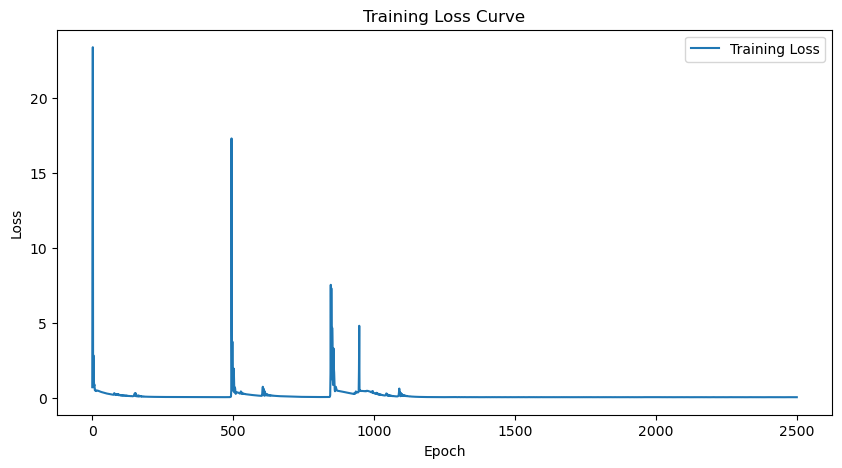

Final Model Accuracy: 81.55%
Final Model F1-score: 0.8410


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

/tmp/ipykernel_3958316/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       160
non_infringement       0.77      0.93      0.84       176

        accuracy                           0.82       336
       macro avg       0.83      0.81      0.81       336
    weighted avg       0.83      0.82      0.81       336



: 